# Calculating Standardized Precipitation Index (SPI)

This notebook demonstrates how to calculate the Standardized Precipitation Index (SPI) using the `precip-index` package with **real TerraClimate data from Bali, Indonesia (1958-2024)**.

**What is SPI?**
- Developed by McKee et al. (1993)
- Transforms precipitation to standard normal distribution
- Allows comparison across different climates and time scales
- **Bidirectional index**: Negative values indicate dry conditions, positive indicate wet conditions

**Learning Objectives:**
1. Load and prepare precipitation data
2. Calculate SPI for single and multiple time scales
3. Save and reuse gamma fitting parameters
4. Visualize results
5. Perform climate extremes classification and analysis

## 1. Setup and Imports

In [1]:
# Add src directory to Python path
import sys
sys.path.insert(0, '../src')

# Core libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime

# Import SPI functions
from indices import (
    spi, 
    spi_multi_scale,
    save_fitting_params,
    load_fitting_params,
    save_index_to_netcdf,
    classify_drought,
    get_drought_area_percentage
)

from config import Periodicity

# Plotting settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All imports successful!")

✓ All imports successful!


## 2. Configuration

Set paths and parameters for your analysis.

In [2]:
# File paths
precip_file = '../input/terraclimate_bali_ppt_1958_2024.nc'

# Variable name
precip_var = 'ppt'

# Calibration period (WMO standard: 1991-2020)
calib_start = 1991
calib_end = 2020

# Output directory
output_dir = '../output/netcdf/'

print("Configuration:")
print(f"  Precipitation file: {precip_file}")
print(f"  Variable: {precip_var}")
print(f"  Calibration period: {calib_start}-{calib_end}")

Configuration:
  Precipitation file: ../input/terraclimate_bali_ppt_1958_2024.nc
  Variable: ppt
  Calibration period: 1991-2020


## 3. Load Precipitation Data

Load TerraClimate monthly precipitation data for Bali.

In [3]:
# Load precipitation data
ds = xr.open_dataset(precip_file)
precip = ds[precip_var]

print("✓ Data loaded successfully!")
print(f"\nDataset Information:")
print(f"  Shape: {precip.shape}")
print(f"  Dimensions: {precip.dims}")
print(f"  Time range: {precip.time[0].values} to {precip.time[-1].values}")
print(f"  Lat range: {float(precip.lat.min()):.2f}° to {float(precip.lat.max()):.2f}°")
print(f"  Lon range: {float(precip.lon.min()):.2f}° to {float(precip.lon.max()):.2f}°")
print(f"\nStatistics:")
print(f"  Mean: {float(precip.mean()):.1f} mm/month")
print(f"  Min: {float(precip.min()):.1f} mm/month")
print(f"  Max: {float(precip.max()):.1f} mm/month")
print(f"  Zero values: {int((precip == 0).sum())} ({100 * float((precip == 0).sum() / precip.size):.1f}%)")

✓ Data loaded successfully!

Dataset Information:
  Shape: (804, 24, 35)
  Dimensions: ('time', 'lat', 'lon')
  Time range: 1958-01-01T00:00:00.000000000 to 2024-12-01T00:00:00.000000000
  Lat range: -8.94° to -7.98°
  Lon range: 114.35° to 115.77°

Statistics:
  Mean: 158.6 mm/month
  Min: 0.0 mm/month
  Max: 1004.7 mm/month
  Zero values: 0 (0.0%)


### Visualize Precipitation Data

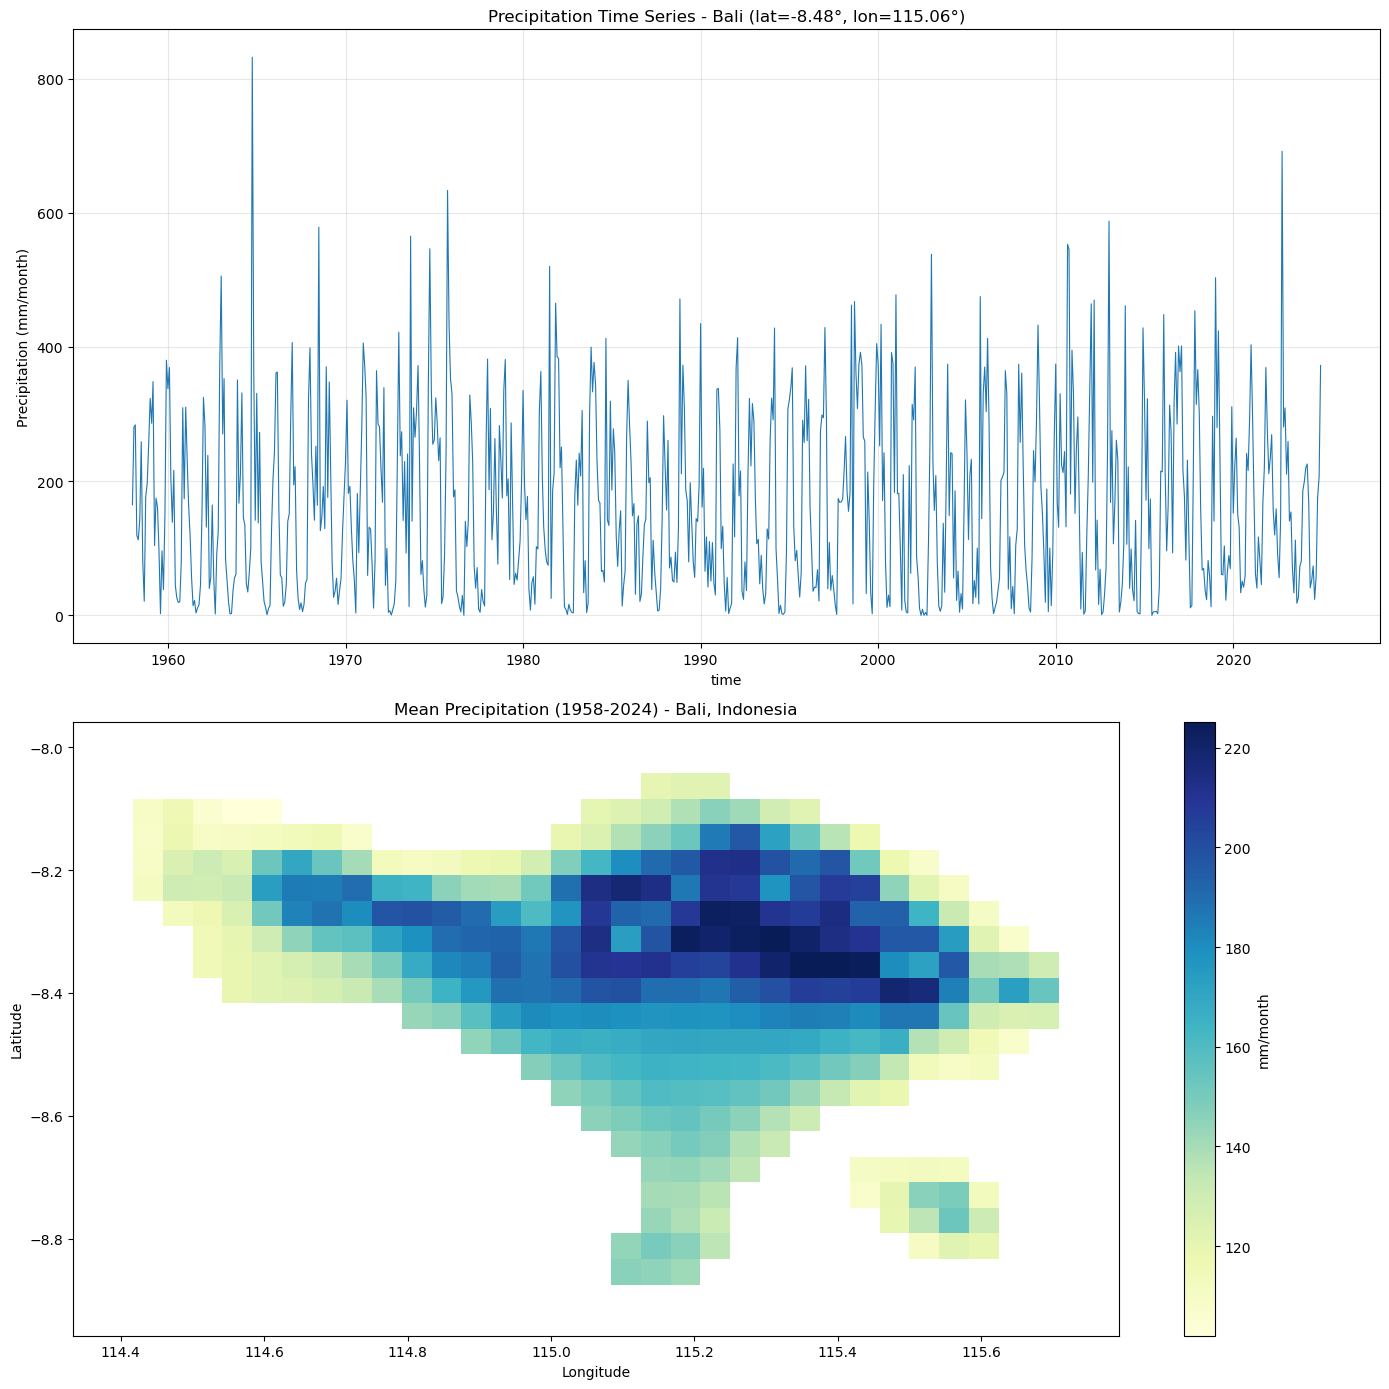

In [12]:
# Select a sample location (center of Bali)
sample_lat_idx = len(precip.lat) // 2
sample_lon_idx = len(precip.lon) // 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

# Time series at sample point
precip[:, sample_lat_idx, sample_lon_idx].plot(ax=ax1, linewidth=0.8)
ax1.set_title(f'Precipitation Time Series - Bali (lat={float(precip.lat[sample_lat_idx]):.2f}°, lon={float(precip.lon[sample_lon_idx]):.2f}°)')
ax1.set_ylabel('Precipitation (mm/month)')
ax1.grid(True, alpha=0.3)

# Spatial pattern (mean over time)
precip.mean(dim='time').plot(ax=ax2, cmap='YlGnBu', cbar_kwargs={'label': 'mm/month'})
ax2.set_title('Mean Precipitation (1958-2024) - Bali, Indonesia')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

## 4. Calculate SPI for a Single Time Scale

Let's calculate SPI-12 (12-month accumulation period) for long-term water resources monitoring.

In [5]:
# Calculate SPI-12
print("Calculating SPI-12...")

spi_12, params = spi(
    precip,
    scale=12,
    periodicity='monthly',
    calibration_start_year=calib_start,
    calibration_end_year=calib_end,
    return_params=True  # Return fitting parameters for saving
)

print("✓ SPI-12 calculation complete!")
print(f"\nOutput Information:")
print(f"  Shape: {spi_12.shape}")
print(f"  Valid range: [{float(spi_12.min()):.2f}, {float(spi_12.max()):.2f}]")
print(f"  Mean: {float(spi_12.mean()):.3f}")
print(f"  Std: {float(spi_12.std()):.3f}")
print(f"  NaN values: {int(np.isnan(spi_12).sum())} ({100 * float(np.isnan(spi_12).sum() / spi_12.size):.1f}%)")

2026-01-24 21:37:35 | INFO     | indices | Computing SPI-12
2026-01-24 21:37:35 | INFO     | indices | Input shape: (804, 24, 35), dims: ('time', 'lat', 'lon'), data_start_year: 1958
2026-01-24 21:37:35 | INFO     | compute | Computing index: shape=(804, 24, 35), scale=12, grid_cells=840
2026-01-24 21:37:35 | INFO     | compute | Step 1/3: Applying temporal scaling...
2026-01-24 21:37:35 | INFO     | compute | Step 2/3: Computing gamma parameters...
2026-01-24 21:37:35 | INFO     | compute | Step 3/3: Transforming to standard normal...
2026-01-24 21:37:35 | INFO     | compute | Index computation complete


Calculating SPI-12...


2026-01-24 21:37:35 | INFO     | indices | SPI-12 computation complete. Output shape: (804, 24, 35)


✓ SPI-12 calculation complete!

Output Information:
  Shape: (804, 24, 35)
  Valid range: [-2.99, 2.71]
  Mean: -0.083
  Std: 0.992
  NaN values: 422393 (62.5%)


### Visualize SPI-12 Results

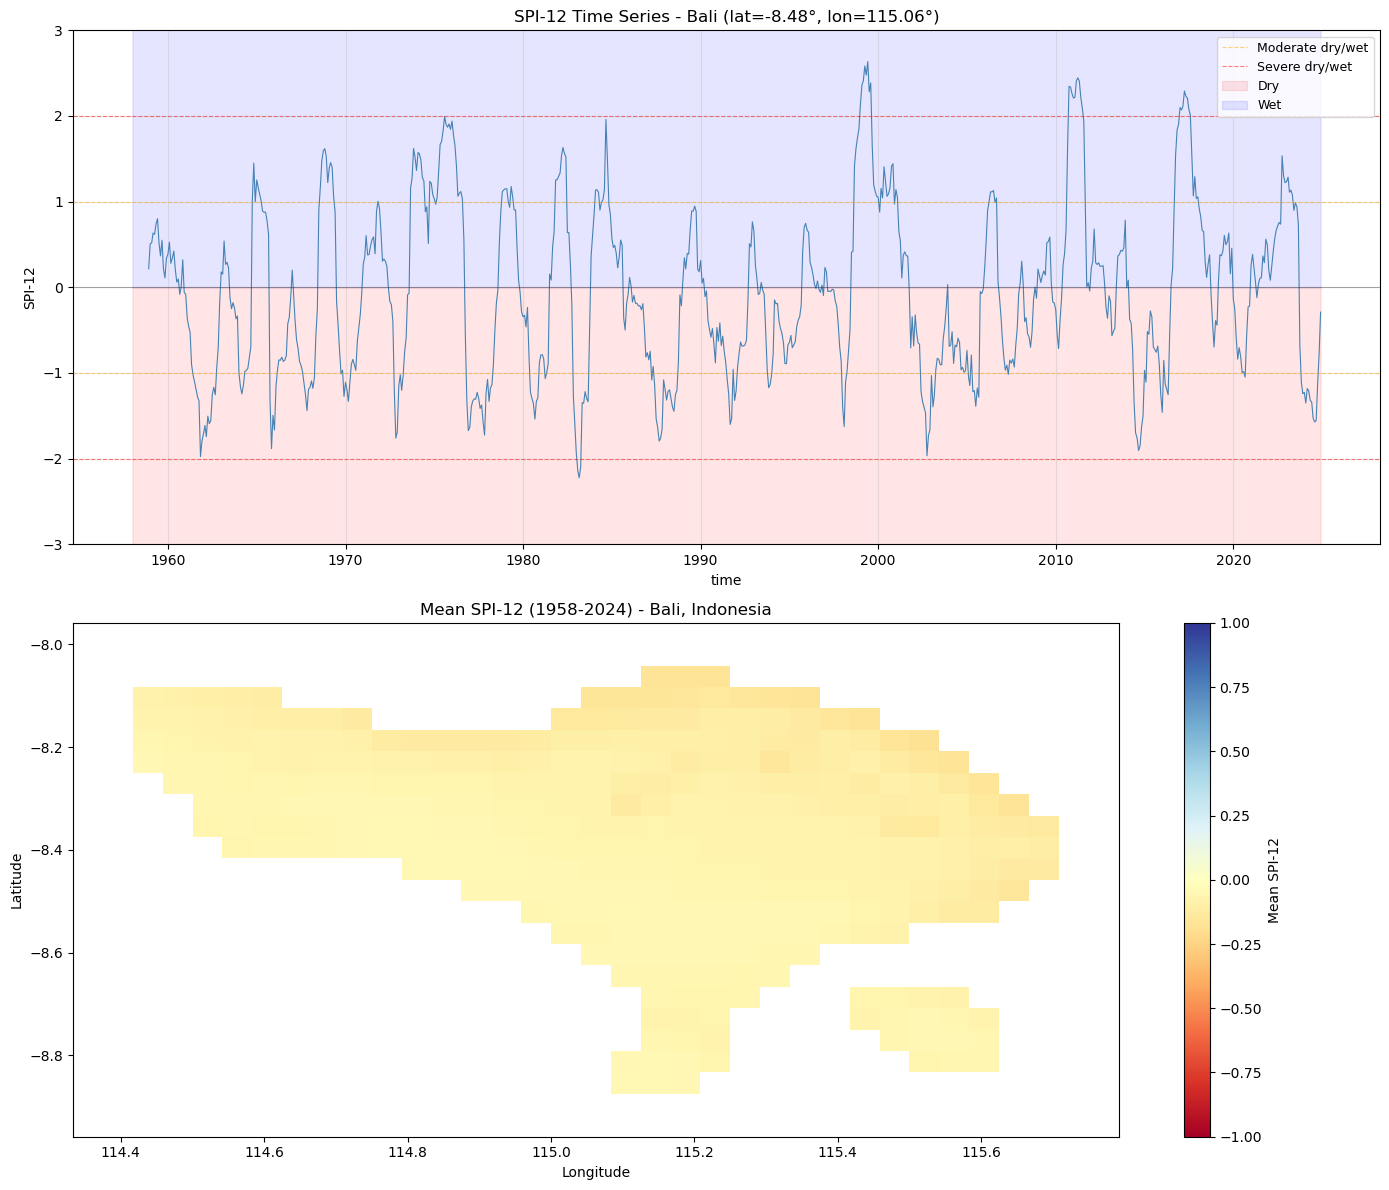

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Time series at sample point
spi_12[:, sample_lat_idx, sample_lon_idx].plot(ax=ax1, linewidth=0.8, color='steelblue')
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.8, alpha=0.3)
ax1.axhline(y=-1.0, color='orange', linestyle='--', linewidth=0.8, alpha=0.5, label='Moderate dry/wet')
ax1.axhline(y=-2.0, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='Severe dry/wet')
ax1.axhline(y=1.0, color='orange', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.axhline(y=2.0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.fill_between(spi_12.time, -10, 0, alpha=0.1, color='red', label='Dry')
ax1.fill_between(spi_12.time, 0, 10, alpha=0.1, color='blue', label='Wet')
ax1.set_title(f'SPI-12 Time Series - Bali (lat={float(precip.lat[sample_lat_idx]):.2f}°, lon={float(precip.lon[sample_lon_idx]):.2f}°)')
ax1.set_ylabel('SPI-12')
ax1.set_ylim(-3, 3)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=9)

# Spatial pattern (mean over time)
spi_12.mean(dim='time').plot(ax=ax2, cmap='RdYlBu', vmin=-1, vmax=1, 
                              cbar_kwargs={'label': 'Mean SPI-12'})
ax2.set_title('Mean SPI-12 (1958-2024) - Bali, Indonesia')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

## 5. Save Fitting Parameters for Reuse

Gamma fitting parameters can be saved and reused to speed up calculations on new data with the same calibration period.

In [7]:
# Save parameters
param_file = output_dir + 'spi_gamma_params_12_month_bali.nc'

save_fitting_params(
    params,
    param_file,
    scale=12,
    periodicity='monthly',
    index_type='spi',
    calibration_start_year=calib_start,
    calibration_end_year=calib_end,
    coords={'lat': precip.lat, 'lon': precip.lon}
)

print(f"✓ Parameters saved to: {param_file}")

# Load parameters
loaded_params = load_fitting_params(param_file, scale=12, periodicity='monthly')
print(f"✓ Parameters loaded successfully")
print(f"  Alpha shape: {loaded_params['alpha'].shape}")
print(f"  Beta shape: {loaded_params['beta'].shape}")
print(f"  Prob_zero shape: {loaded_params['prob_zero'].shape}")

2026-01-24 21:37:35 | INFO     | indices | Saving fitting parameters to: ../output/netcdf/spi_gamma_params_12_month_bali.nc
2026-01-24 21:37:37 | INFO     | indices | Fitting parameters saved: ../output/netcdf/spi_gamma_params_12_month_bali.nc
2026-01-24 21:37:37 | INFO     | indices | Loading fitting parameters from: ../output/netcdf/spi_gamma_params_12_month_bali.nc
2026-01-24 21:37:37 | INFO     | indices | Loaded parameters for scale=12, periodicity=monthly, shape=(12, 24, 35)


✓ Parameters saved to: ../output/netcdf/spi_gamma_params_12_month_bali.nc
✓ Parameters loaded successfully
  Alpha shape: (12, 24, 35)
  Beta shape: (12, 24, 35)
  Prob_zero shape: (12, 24, 35)


### Use Pre-computed Parameters (Faster)

In [8]:
# Calculate SPI using pre-computed parameters
# This is much faster when processing multiple datasets
print("Calculating SPI-12 with pre-computed parameters...")

spi_12_fast = spi(
    precip,
    scale=12,
    periodicity='monthly',
    fitting_params=loaded_params
)

print("✓ Calculation complete!")

# Verify results are identical
diff = np.abs(spi_12.values - spi_12_fast.values)
max_diff = np.nanmax(diff)
print(f"  Max difference from original: {max_diff:.10f}")
print("  Results are identical!" if max_diff < 1e-6 else "  Warning: Results differ!")

2026-01-24 21:37:37 | INFO     | indices | Computing SPI-12
2026-01-24 21:37:37 | INFO     | indices | Input shape: (804, 24, 35), dims: ('time', 'lat', 'lon'), data_start_year: 1958
2026-01-24 21:37:37 | INFO     | compute | Computing index: shape=(804, 24, 35), scale=12, grid_cells=840
2026-01-24 21:37:37 | INFO     | compute | Step 1/3: Applying temporal scaling...


Calculating SPI-12 with pre-computed parameters...


2026-01-24 21:37:37 | INFO     | compute | Step 2/3: Computing gamma parameters...
2026-01-24 21:37:37 | INFO     | compute | Using pre-computed fitting parameters
2026-01-24 21:37:37 | INFO     | compute | Step 3/3: Transforming to standard normal...
2026-01-24 21:37:37 | INFO     | compute | Index computation complete
2026-01-24 21:37:37 | INFO     | indices | SPI-12 computation complete. Output shape: (804, 24, 35)


✓ Calculation complete!
  Max difference from original: 0.0000006265
  Results are identical!


## 6. Calculate SPI for Multiple Time Scales

Different time scales capture different types of climate extremes:
- **SPI-1**: Short-term meteorological (precipitation deficit/excess)
- **SPI-3**: Seasonal agricultural (crop water stress/flooding)
- **SPI-6**: Medium-term hydrological (reservoir/groundwater)
- **SPI-12**: Long-term water resources (multi-year planning)

In [9]:
# Calculate multiple scales
print("Calculating SPI for scales: 1, 3, 6, 12 months...")

spi_multi = spi_multi_scale(
    precip,
    scales=[1, 3, 6, 12],
    periodicity='monthly',
    calibration_start_year=calib_start,
    calibration_end_year=calib_end
)

print("✓ Multi-scale SPI calculation complete!")
print(f"  Variables: {list(spi_multi.data_vars)}")

2026-01-24 21:37:37 | INFO     | indices | Computing SPI for scales: [1, 3, 6, 12]
2026-01-24 21:37:37 | INFO     | indices | Processing scale 1...


Calculating SPI for scales: 1, 3, 6, 12 months...


2026-01-24 21:37:37 | INFO     | indices | Computing SPI-1
2026-01-24 21:37:37 | INFO     | indices | Input shape: (804, 24, 35), dims: ('time', 'lat', 'lon'), data_start_year: 1958
2026-01-24 21:37:37 | INFO     | compute | Computing index: shape=(804, 24, 35), scale=1, grid_cells=840
2026-01-24 21:37:37 | INFO     | compute | Step 1/3: Applying temporal scaling...
2026-01-24 21:37:37 | INFO     | compute | Step 2/3: Computing gamma parameters...
2026-01-24 21:37:37 | INFO     | compute | Step 3/3: Transforming to standard normal...
2026-01-24 21:37:37 | INFO     | compute | Index computation complete
2026-01-24 21:37:37 | INFO     | indices | SPI-1 computation complete. Output shape: (804, 24, 35)
2026-01-24 21:37:37 | INFO     | indices | Processing scale 3...
2026-01-24 21:37:37 | INFO     | indices | Computing SPI-3
2026-01-24 21:37:37 | INFO     | indices | Input shape: (804, 24, 35), dims: ('time', 'lat', 'lon'), data_start_year: 1958
2026-01-24 21:37:37 | INFO     | compute | C

✓ Multi-scale SPI calculation complete!
  Variables: ['spi_gamma_1_month', 'spi_gamma_3_month', 'spi_gamma_6_month', 'spi_gamma_12_month']


### Compare Different Time Scales

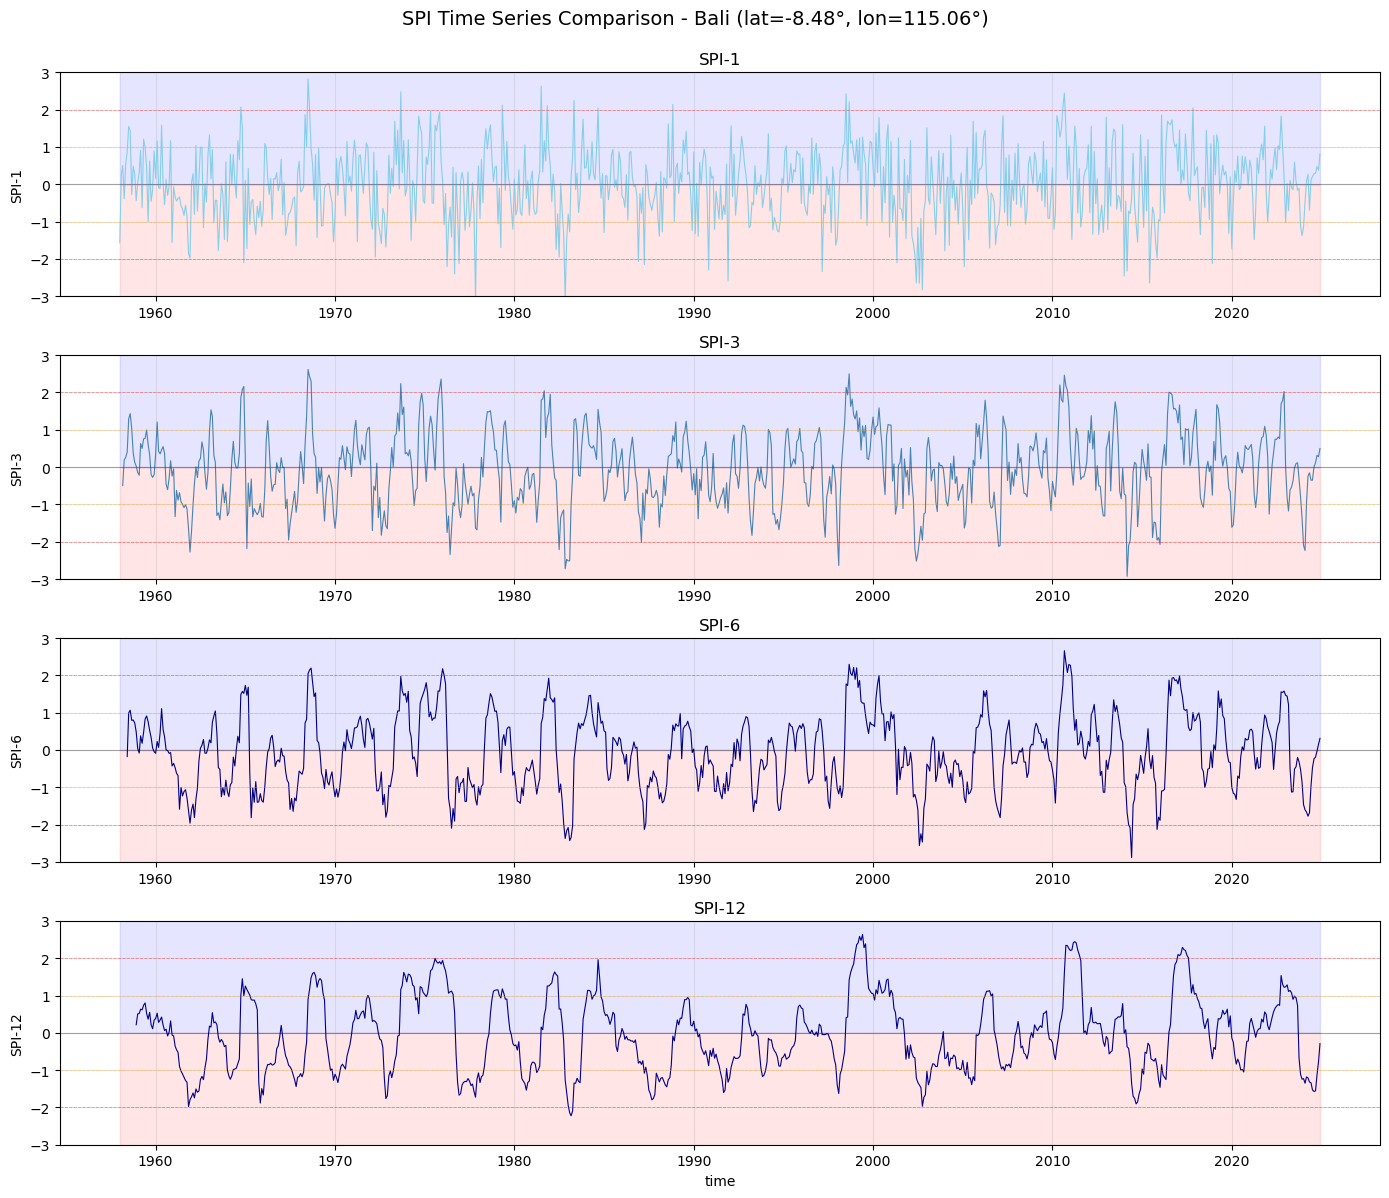


Observations:
  - SPI-1 shows high frequency variability (month-to-month)
  - SPI-12 shows smoother, longer-term trends
  - Extreme events persist longer at longer time scales


In [10]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

scales = [1, 3, 6, 12]
colors = ['skyblue', 'steelblue', 'navy', 'darkblue']

for i, (scale, color) in enumerate(zip(scales, colors)):
    var_name = f'spi_gamma_{scale}_month'
    spi_data = spi_multi[var_name]
    
    # Plot time series
    spi_data[:, sample_lat_idx, sample_lon_idx].plot(
        ax=axes[i], 
        linewidth=0.8, 
        color=color
    )
    
    # Add reference lines
    axes[i].axhline(y=0, color='k', linestyle='-', linewidth=0.8, alpha=0.3)
    axes[i].axhline(y=-1.0, color='orange', linestyle='--', linewidth=0.6, alpha=0.4)
    axes[i].axhline(y=-2.0, color='red', linestyle='--', linewidth=0.6, alpha=0.4)
    axes[i].axhline(y=1.0, color='orange', linestyle='--', linewidth=0.6, alpha=0.4)
    axes[i].axhline(y=2.0, color='red', linestyle='--', linewidth=0.6, alpha=0.4)
    axes[i].fill_between(spi_data.time, -10, 0, alpha=0.1, color='red')
    axes[i].fill_between(spi_data.time, 0, 10, alpha=0.1, color='blue')
    
    axes[i].set_title(f'SPI-{scale}')
    axes[i].set_ylabel(f'SPI-{scale}')
    axes[i].set_ylim(-3, 3)
    axes[i].grid(True, alpha=0.3)
    
    if i < 3:
        axes[i].set_xlabel('')

plt.suptitle(f'SPI Time Series Comparison - Bali (lat={float(precip.lat[sample_lat_idx]):.2f}°, lon={float(precip.lon[sample_lon_idx]):.2f}°)', 
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("  - SPI-1 shows high frequency variability (month-to-month)")
print("  - SPI-12 shows smoother, longer-term trends")
print("  - Extreme events persist longer at longer time scales")

## 7. Climate Extremes Classification

McKee et al. (1993) classification scheme - works for both dry and wet extremes.

In [11]:
# Display SPI-12 classification scheme
print("SPI-12 Classification (11 Categories):")
print("=" * 60)
print("  -2.00 and below    : Exceptionally dry")
print("  -2.00 to -1.50     : Extremely dry")
print("  -1.50 to -1.20     : Severely dry")
print("  -1.20 to -0.70     : Moderately dry")
print("  -0.70 to -0.50     : Abnormally dry")
print("  -0.50 to +0.50     : Near normal")
print("  +0.50 to +0.70     : Abnormally moist")
print("  +0.70 to +1.20     : Moderately moist")
print("  +1.20 to +1.50     : Very moist")
print("  +1.50 to +2.00     : Extremely moist")
print("  +2.00 and above    : Exceptionally moist")
print()

# Count occurrences by category
print("Frequency Distribution (Bali, 1958-2024):")
print("=" * 60)

# Define boundaries
bounds = [-3.0, -2.0, -1.5, -1.2, -0.7, -0.5, 0.5, 0.7, 1.2, 1.5, 2.0, 3.0]
categories = [
    'Exceptionally dry',
    'Extremely dry',
    'Severely dry',
    'Moderately dry',
    'Abnormally dry',
    'Near normal',
    'Abnormally moist',
    'Moderately moist',
    'Very moist',
    'Extremely moist',
    'Exceptionally moist'
]

# Count values in each category
valid_values = spi_12.values[~np.isnan(spi_12.values)]
total_count = len(valid_values)

for i in range(len(bounds) - 1):
    lower = bounds[i]
    upper = bounds[i + 1]
    
    if i == 0:  # First category (below -2.0)
        count = np.sum(valid_values <= upper)
    elif i == len(bounds) - 2:  # Last category (above +2.0)
        count = np.sum(valid_values > lower)
    else:
        count = np.sum((valid_values > lower) & (valid_values <= upper))
    
    pct = 100 * count / total_count
    print(f"  {categories[i]:20s}: {count:6d} ({pct:5.1f}%)")

SPI-12 Classification (11 Categories):
  -2.00 and below    : Exceptionally dry
  -2.00 to -1.50     : Extremely dry
  -1.50 to -1.20     : Severely dry
  -1.20 to -0.70     : Moderately dry
  -0.70 to -0.50     : Abnormally dry
  -0.50 to +0.50     : Near normal
  +0.50 to +0.70     : Abnormally moist
  +0.70 to +1.20     : Moderately moist
  +1.20 to +1.50     : Very moist
  +1.50 to +2.00     : Extremely moist
  +2.00 and above    : Exceptionally moist

Frequency Distribution (Bali, 1958-2024):
  Exceptionally dry   :   2793 (  1.1%)
  Extremely dry       :  13697 (  5.4%)
  Severely dry        :  18770 (  7.4%)
  Moderately dry      :  40964 ( 16.2%)
  Abnormally dry      :  17329 (  6.9%)
  Near normal         :  88123 ( 34.8%)
  Abnormally moist    :  14305 (  5.7%)
  Moderately moist    :  28842 ( 11.4%)
  Very moist          :  12321 (  4.9%)
  Extremely moist     :   9632 (  3.8%)
  Exceptionally moist :   6191 (  2.4%)


### Visualize Climate Extremes Categories

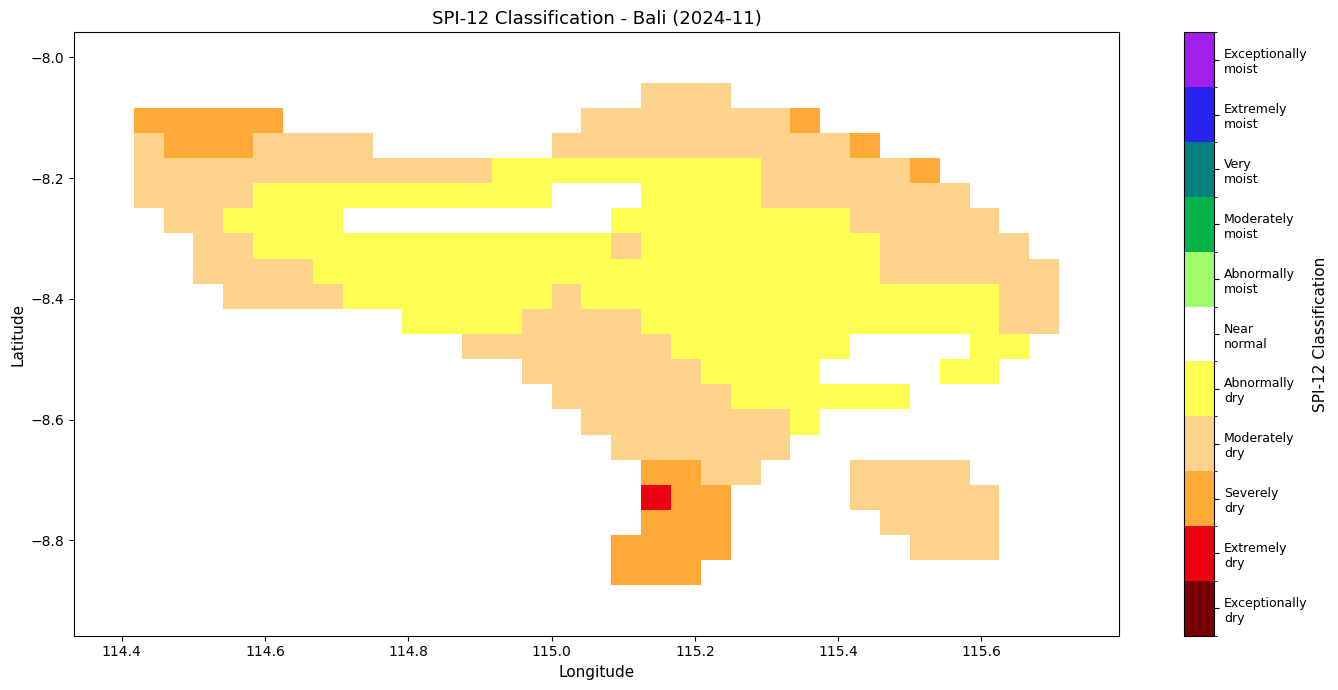

In [16]:
# Plot climate extremes category map for the latest month
time_idx = -2  # Latest month (Dec 2024)

fig, ax = plt.subplots(figsize=(14, 7))

# Custom colormap for climate extremes categories (WMO-style colors)
from matplotlib.colors import ListedColormap, BoundaryNorm

# SPI classification colors (11 categories)
colors = [
    '#760005',  # Exceptionally dry: -2.00 and below
    '#ec0013',  # Extremely dry: -2.00 to -1.50
    '#ffa938',  # Severely dry: -1.50 to -1.20
    '#fdd28a',  # Moderately dry: -1.20 to -0.70
    '#fefe53',  # Abnormally dry: -0.70 to -0.50
    '#ffffff',  # Near normal: -0.50 to +0.50
    '#a2fd6e',  # Abnormally moist: +0.50 to +0.70
    '#00b44a',  # Moderately moist: +0.70 to +1.20
    '#008180',  # Very moist: +1.20 to +1.50
    '#2a23eb',  # Extremely moist: +1.50 to +2.00
    '#a21fec'   # Exceptionally moist: +2.00 and above
]

# Define boundaries for 11 categories
bounds = [-3.0, -2.0, -1.5, -1.2, -0.7, -0.5, 0.5, 0.7, 1.2, 1.5, 2.0, 3.0]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

# Extract data for plotting
spi_data = spi_12.isel(time=time_idx)

# Create meshgrid for pcolormesh
lon_2d, lat_2d = np.meshgrid(spi_12.lon.values, spi_12.lat.values)

# Plot using pcolormesh
im = ax.pcolormesh(
    lon_2d,
    lat_2d,
    spi_data.values,  # Use SPI values directly for fine-grained classification
    cmap=cmap,
    norm=norm,
    shading='auto'
)

# Colorbar with all 11 categories
cbar = plt.colorbar(im, ax=ax, ticks=[-2.5, -1.75, -1.35, -0.95, -0.6, 0, 0.6, 0.95, 1.35, 1.75, 2.5])
cbar.set_label('SPI-12 Classification', fontsize=11)
cbar.ax.set_yticklabels([
    'Exceptionally\ndry',
    'Extremely\ndry', 
    'Severely\ndry',
    'Moderately\ndry',
    'Abnormally\ndry',
    'Near\nnormal',
    'Abnormally\nmoist',
    'Moderately\nmoist',
    'Very\nmoist',
    'Extremely\nmoist',
    'Exceptionally\nmoist'
], fontsize=9)

ax.set_title(f'SPI-12 Classification - Bali ({str(spi_12.time[time_idx].values)[:7]})', fontsize=13)
ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude', fontsize=11)

plt.tight_layout()
plt.show()

## 8. Area Percentage Analysis

Calculate the percentage of area experiencing dry or wet conditions over time.

In [17]:
# Calculate dry area percentage time series
# Threshold -1.0 = moderate dry or worse
dry_pct = get_drought_area_percentage(spi_12, threshold=-1.0)

# Calculate wet area percentage time series  
# For wet events, we need to invert the logic
wet_pct = 100 * (spi_12 >= 1.0).sum(dim=['lat', 'lon']) / (spi_12.sizes['lat'] * spi_12.sizes['lon'])

print(f"Dry Area Statistics (SPI <= -1.0):")
print(f"  Mean: {float(dry_pct.mean()):.1f}%")
print(f"  Max: {float(dry_pct.max()):.1f}%")
print(f"  Min: {float(dry_pct.min()):.1f}%")

print(f"\nWet Area Statistics (SPI >= +1.0):")
print(f"  Mean: {float(wet_pct.mean()):.1f}%")
print(f"  Max: {float(wet_pct.max()):.1f}%")
print(f"  Min: {float(wet_pct.min()):.1f}%")

Dry Area Statistics (SPI <= -1.0):
  Mean: 20.2%
  Max: 100.0%
  Min: 0.0%

Wet Area Statistics (SPI >= +1.0):
  Mean: 5.8%
  Max: 38.0%
  Min: 0.0%


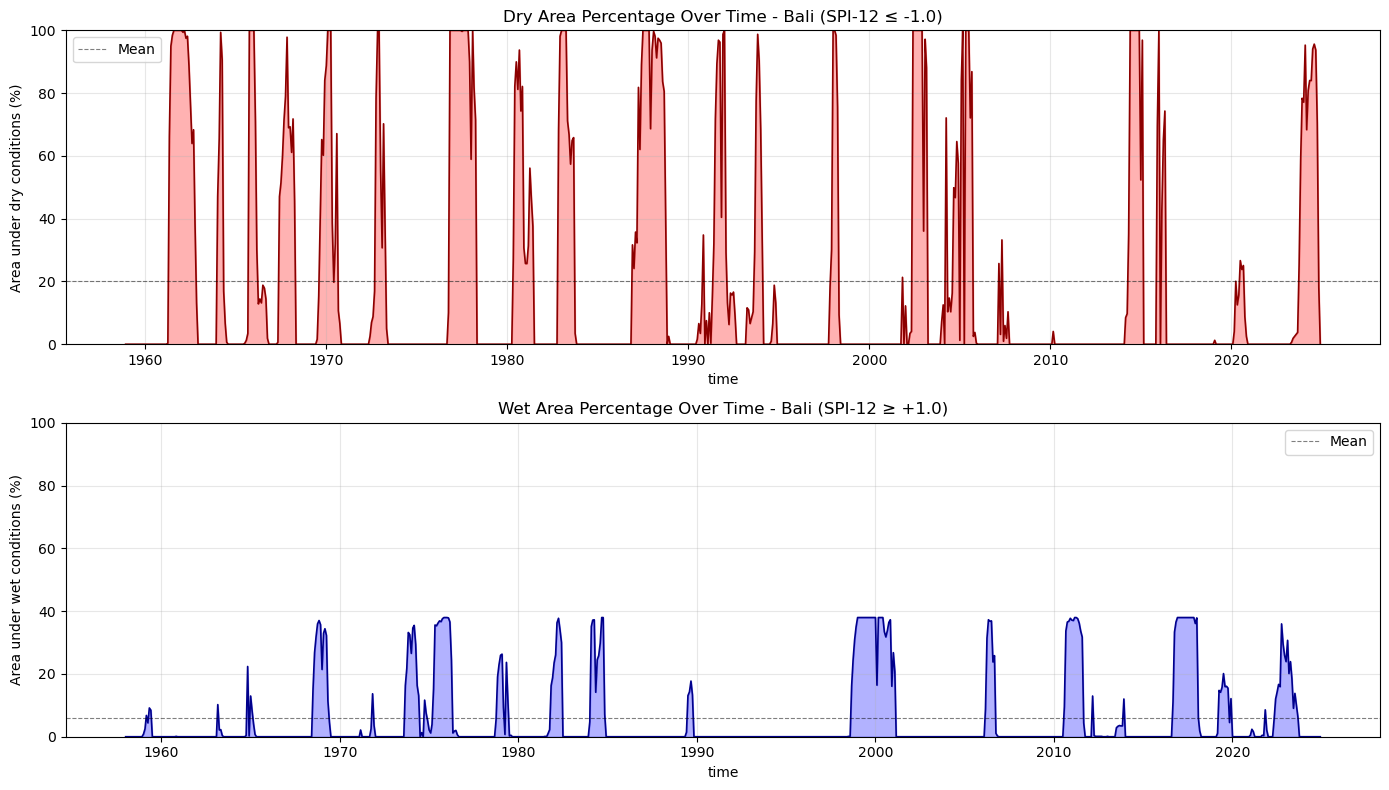

In [18]:
# Plot dry and wet area percentages over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Dry area
dry_pct.plot(ax=ax1, linewidth=1.2, color='darkred')
ax1.axhline(y=dry_pct.mean(), color='k', linestyle='--', linewidth=0.8, alpha=0.5, label='Mean')
ax1.fill_between(dry_pct.time, 0, dry_pct, alpha=0.3, color='red')
ax1.set_title('Dry Area Percentage Over Time - Bali (SPI-12 ≤ -1.0)', fontsize=12)
ax1.set_ylabel('Area under dry conditions (%)')
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Wet area
wet_pct.plot(ax=ax2, linewidth=1.2, color='darkblue')
ax2.axhline(y=wet_pct.mean(), color='k', linestyle='--', linewidth=0.8, alpha=0.5, label='Mean')
ax2.fill_between(wet_pct.time, 0, wet_pct, alpha=0.3, color='blue')
ax2.set_title('Wet Area Percentage Over Time - Bali (SPI-12 ≥ +1.0)', fontsize=12)
ax2.set_ylabel('Area under wet conditions (%)')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## 9. Save Results to NetCDF

In [19]:
# Save single-scale SPI
output_file_single = output_dir + 'spi_12_bali.nc'
save_index_to_netcdf(spi_12, output_file_single, compress=True, complevel=5)
print(f"✓ SPI-12 saved to: {output_file_single}")

# Save multi-scale SPI
output_file_multi = output_dir + 'spi_multi_scale_bali.nc'
save_index_to_netcdf(spi_multi, output_file_multi, compress=True, complevel=5)
print(f"✓ Multi-scale SPI saved to: {output_file_multi}")

# Save area percentages
dry_pct.to_netcdf(output_dir + 'dry_area_percentage_bali.nc')
print(f"✓ Dry area percentage saved to: {output_dir}dry_area_percentage_bali.nc")

wet_pct.to_netcdf(output_dir + 'wet_area_percentage_bali.nc')
print(f"✓ Wet area percentage saved to: {output_dir}wet_area_percentage_bali.nc")

2026-01-24 21:41:31 | INFO     | indices | Saving to: ../output/netcdf/spi_12_bali.nc
2026-01-24 21:41:32 | INFO     | indices | Saved: ../output/netcdf/spi_12_bali.nc
2026-01-24 21:41:32 | INFO     | indices | Saving to: ../output/netcdf/spi_multi_scale_bali.nc


✓ SPI-12 saved to: ../output/netcdf/spi_12_bali.nc


2026-01-24 21:41:32 | INFO     | indices | Saved: ../output/netcdf/spi_multi_scale_bali.nc


✓ Multi-scale SPI saved to: ../output/netcdf/spi_multi_scale_bali.nc
✓ Dry area percentage saved to: ../output/netcdf/dry_area_percentage_bali.nc
✓ Wet area percentage saved to: ../output/netcdf/wet_area_percentage_bali.nc


## 10. Summary and Best Practices

### Key Takeaways:
1. ✅ **Data Format**: Ensure data follows CF Convention (time, lat, lon)
2. ✅ **Calibration Period**: Use 30-year period (WMO recommends 1991-2020)
3. ✅ **Parameter Reuse**: Save fitting parameters for faster processing
4. ✅ **Time Scales**: Choose based on application (1=meteorological, 3=agricultural, 6=hydrological, 12=water resources)
5. ✅ **Bidirectional**: SPI monitors both dry and wet extremes equally
6. ✅ **Validation**: Always visualize results before using in analysis

### Recommended Workflow:
```python
# 1. Load data
ds = xr.open_dataset('precip.nc')
precip = ds['precip']

# 2. Calculate SPI with parameter saving
spi_12, params = spi(precip, scale=12, return_params=True,
                     calibration_start_year=1991, calibration_end_year=2020)

# 3. Save parameters for reuse
save_fitting_params(params, 'params.nc', scale=12, periodicity='monthly')

# 4. Reuse on new data (much faster!)
params = load_fitting_params('params.nc', scale=12, periodicity='monthly')
spi_12_new = spi(new_precip, scale=12, fitting_params=params)

# 5. Analyze both dry and wet extremes
dry_pct = get_drought_area_percentage(spi_12, threshold=-1.0)
wet_pct = 100 * (spi_12 >= 1.0).sum(dim=['lat','lon']) / (spi_12.sizes['lat']*spi_12.sizes['lon'])
```

### Next Steps:
- 📓 **Notebook 02**: Calculate SPEI (temperature-inclusive index)
- 📓 **Notebook 03**: Analyze climate extreme events using run theory
- 📓 **Notebook 04**: Explore comprehensive visualization gallery